In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import plotly.graph_objs as go
import chart_studio.plotly as py
#cufflinks is a wrapper library around plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [13]:
doc = pd.read_csv('yelp.csv')

__Preprocess as before__

In [14]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def process_message(message):
    """
    This function takes in a string of text, then performs the followings:
    1. Removes all punctuation
    2. Removes all stopwords
    3. Returns a list of the cleaned text
    """
    # Checking to see if they are in punctuation
    nopunc = [char for char in message if char not in string.punctuation]

    
    nopunc = ''.join(nopunc)
    
    #  removing any stopwords
    out = []
    for word in nopunc.split():
        if word.lower() not in stopwords.words('english'):
            out.append(word)
            
    return out

In [18]:
# see the head again
messages = doc[['stars', 'text']]
messages.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [20]:
# Vectorize the reviews using keras' Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [21]:

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# updates internal vocabulary
tokenizer.fit_on_texts(messages['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34072 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(messages['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X:', X.shape)

Shape of X: (10000, 250)


In [24]:
Y = pd.get_dummies(messages['stars']).values
print('Shape of label Y:', Y.shape)

Shape of label Y: (10000, 5)


In [25]:
# split into test and train
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7000, 250) (7000, 5)
(3000, 250) (3000, 5)


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


In [31]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [38]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 92s 15ms/step - loss: 0.2407 - accuracy: 0.9190 - val_loss: 1.7822 - val_accuracy: 0.5057
Epoch 2/10
6300/6300 [==============================] - 96s 15ms/step - loss: 0.1954 - accuracy: 0.9363 - val_loss: 1.9399 - val_accuracy: 0.4900
Epoch 3/10
6300/6300 [==============================] - 98s 16ms/step - loss: 0.1786 - accuracy: 0.9381 - val_loss: 2.0469 - val_accuracy: 0.4886
Epoch 4/10
6300/6300 [==============================] - 90s 14ms/step - loss: 0.1335 - accuracy: 0.9549 - val_loss: 2.1526 - val_accuracy: 0.4629


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3000/3000 [==============================] - 10s 3ms/step
Test set
  Loss: 1.693
  Accuracy: 0.574


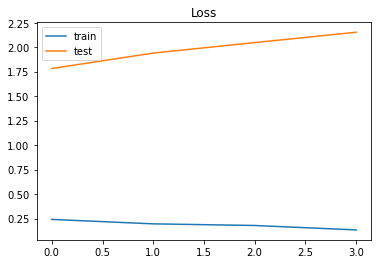

In [40]:

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

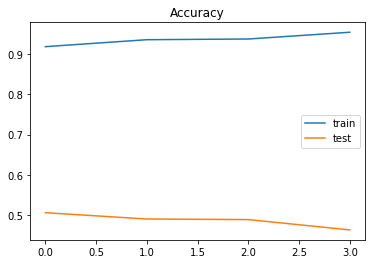

In [43]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [47]:
new_review = ["Even though we had to wait for 25 minutes,we actually liked the food. Especially my wife liked the dissert. The prices were reasonable too"]


seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = [1,2,3,4,5]
print(pred, labels[np.argmax(pred)])

[[1.2206519e-04 3.8232253e-04 1.4652582e-02 9.7953528e-01 5.3077140e-03]] 4
